In [0]:
displayHTML('''
<center><br> <img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Amazon_2024.svg" style="width: 200px;"></center><br>
''')

In [0]:
displayHTML('''
<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #d9345b;">BDA Project |</span> <span style="color: #2a2a83;">Sentiment Analysis on Amazon Reviews of Electronics</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>João Henriques, 20240499</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>
''')

BDA Project | Sentiment Analysis on Amazon Reviews of Electronics 
 
 
 Spring Semester | 2024 - 2025
 
 
 Master in Data Science and Advanced Analytics
 
 
 André Silvestre, 20240502 
 Filipa Pereira, 20240509 
 João Henriques, 20240499 
 Umeima Mahomed, 20240543 
 
 
 Group 37

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 7px; color: white; border-radius: 500px; text-align: center;">
</div>

### **PySpark Session**

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
#         https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr
#         https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics_GraphAnalysis")
         .config("spark.driver.memory", "15g")                              # Adjust memory for driver
         .config("spark.executor.memory", "15g")                            # Adjust memory per executor
         .config("spark.sql.execution.arrow.pyspark.enabled", "true")       # Enable Arrow for faster conversion to Pandas
         .config("spark.sql.execution.arrow.enabled", "true")               # Enable Arrow for Spark SQL
         .getOrCreate())

## 📚 **Libraries Import**

#### **GraphFrames**
**GraphFrames** is a library that extends GraphX, using DataFrames instead of RDDs, and is highly recommended in Databricks. It offers additional functionalities such as expressive queries and motif finding, and is more integrated with the current Spark ecosystem.(https://docs.databricks.com/aws/en/integrations/graphframes/)

- **Check if GraphFrames is installed**:
  - In Databricks Community Edition, GraphFrames may not be pre-installed. To install it:
    1. Go to the cluster in the **Compute** menu.
    2. Click on **Libraries** > **Install New** > **Maven**.
    3. Enter the Maven coordinates: `graphframes:graphframes:0.8.2-spark3.1-s_2.12` (adjust the version according to your Spark version).
    4. Install the library.
  - Alternatively, download the GraphFrames JAR (https://spark-packages.org/package/graphframes/graphframes) and upload it to the cluster.

In [0]:
# Imports for System Operations
import os
import sys
import time
import datetime

# Imports for Data Manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Imports for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, to_rgba_array
from math import ceil

# Imports PySpark
from pyspark.sql.types import *
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.functions import when, col

# DISCLAIMER: To run this code, it is necessary to have libraries installed as the instructions above.
# Imports for Graph Analysis
from graphframes import GraphFrame   # GraphFrames library for graph analysis
from pyspark.sql import Row          # Row can be used to create a row object by using named arguments

# =========== Google Colab Installation Commands ==============
# spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.7.0-spark2.4-s_2.11").getOrCreate()
# !pip install graphframes
# !curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
# =============================================================

---

## 🧮 **Import Databases**

### **🟥 Databricks FileStore**

- If you are using Databricks, you can just use the following code to import the dataset:
    - Otherwise, you replace **`%sh`** with **`!`** and run the command in your terminal. Don't forget to replace the path with your local path.


In [0]:
%sh
# Create the directory for the dataset
mkdir -p /databricks/driver/AmazonReviews_Results

# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Reviews)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1tDvn0HvDNLizApdiH6tfpkWBa_WZJOmV&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Reviews)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1tDvn0HvDNLizApdiH6tfpkWBa_WZJOmV&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-25 14:13:57--  https://drive.usercontent.google.com/download?id=1tDvn0HvDNLizApdiH6tfpkWBa_WZJOmV&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.69.161, 2607:f8b0:400a:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.69.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201885891 (193M) [application/octet-stream]
Saving to: ‘/databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip’

     0K .......... .......... .......... .......... ..........  0% 3.87M 50s
    50K .......... .......... .......... .......... ..........  0% 7.38M 38s
   100K .......... .......... .......... .......... ..........  0% 6.72M 35s
   150K .......... .......... .......... .......... ..........  0% 7.44M 33s
   200K .......... .......... .......... .......... ..........  0% 8.64M 30s
   250K .......... .......... .......... .......... ..........  0% 11.2M 28

In [0]:
%sh
# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Products)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1q_SDoW0g7gR0lqsPZoYWPJO3yFC_E8Lw&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Products)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1q_SDoW0g7gR0lqsPZoYWPJO3yFC_E8Lw&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AmazonReviews_Results/df-computers-products-final.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-25 14:14:08--  https://drive.usercontent.google.com/download?id=1q_SDoW0g7gR0lqsPZoYWPJO3yFC_E8Lw&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.69.161, 2607:f8b0:400a:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.69.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5495632 (5.2M) [application/octet-stream]
Saving to: ‘/databricks/driver/AmazonReviews_Results/df-computers-products-final.zip’

     0K .......... .......... .......... .......... ..........  0% 2.69M 2s
    50K .......... .......... .......... .......... ..........  1% 5.06M 1s
   100K .......... .......... .......... .......... ..........  2% 5.22M 1s
   150K .......... .......... .......... .......... ..........  3% 5.77M 1s
   200K .......... .......... .......... .......... ..........  4% 8.19M 1s
   250K .......... .......... .......... .......... ..........  5% 14.4M 1s
   30

In [0]:
%sh
# Print the contents of the driver directory
ls -lh /databricks/driver/

total 1.3M
drwxr-xr-x 4 root root 4.0K May 25 10:50 AmazonReviews_Results
drwxr-xr-x 2 root root 4.0K May 25 02:33 azure
drwxr-xr-x 2 root root 4.0K May 25 02:33 conf
drwxr-xr-x 3 root root 4.0K May 25 10:48 eventlogs
drwxr-xr-x 2 root root 4.0K May 25 14:11 ganglia
-r-xr-xr-x 1 root root 2.7K May 25 02:33 hadoop_accessed_config.lst
drwxr-xr-x 2 root root 4.0K May 25 14:13 logs
drwxr-xr-x 5 root root 4.0K May 25 10:49 metastore_db
-r-xr-xr-x 1 root root 1.3M May 25 02:33 preload_class.lst


In [0]:
%sh
# Unzip the downloaded files
unzip  /databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip -d  /databricks/driver/AmazonReviews_Results/df-computers-reviews-final
unzip  /databricks/driver/AmazonReviews_Results/df-computers-products-final.zip -d  /databricks/driver/AmazonReviews_Results/df-computers-products-final

# List the unzipped files
ls -lh  /databricks/driver/AmazonReviews_Results/

Archive:  /databricks/driver/AmazonReviews_Results/df-computers-reviews-final.zip


---

### **🧮 PySpark Load Data**

In [0]:
# Import Data (Products and Reviews from Amazon since 2022 - Electronics.Computers | Final Results)

# Read the reviews DataFrame
reviews_df = spark.read.parquet("file:/databricks/driver/AmazonReviews_Results/df-computers-reviews-final/")  # Databricks Path

# Read the products/metadata DataFrame
products_df = spark.read.parquet("file:/databricks/driver/AmazonReviews_Results/df-computers-products-final/")  # Databricks Path

### **Reviews**

In [0]:
# Verification of the first observation and schema (Reviews)
reviews_df.printSchema()
reviews_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", reviews_df.count())
print("\033[1mNumber of Features:\033[0m ", len(reviews_df.columns))

root
 |-- review_id: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- TXRBSF_SentimentLabel: string (nullable = true)
 |-- TXRBSF_SentimentScore: double (nullable = true)
 |-- mDeBERTa_SentimentLabel: string (nullable = true)
 |-- mDeBERTa_SentimentScore: double (nullable = true)
 |-- Combined_Sentiment: string (nullable = true)
 |-- n_reviews_text: integer (nullable = true)

-RECORD 0---------------------------------------
 review_id               | 415552               
 review_text             | Best Case so far ... 
 parent_

### **Products/Metadata**

In [0]:
# Verification of the first observation and schema (Products)
products_df.printSchema()
products_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", products_df.count())
print("\033[1mNumber of Features:\033[0m ", len(products_df.columns))

root
 |-- parent_asin: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- meta_average_rating: double (nullable = true)
 |-- meta_rating_number: integer (nullable = true)
 |-- meta_price: double (nullable = true)
 |-- meta_store: string (nullable = true)
 |-- TopicLabel: string (nullable = true)
 |-- TopicScore: double (nullable = true)
 |-- n_product_title: integer (nullable = true)

-RECORD 0-----------------------------------
 parent_asin         | 0594149290           
 product_title       | Barnes Noble Nook... 
 meta_average_rating | 4.0                  
 meta_rating_number  | 12                   
 meta_price          | 147.95               
 meta_store          | Barnes & Noble       
 TopicLabel          | Drives and Storage   
 TopicScore          | 0.28259041905403137  
 n_product_title     | 11                   
only showing top 1 row


Number of Observations:  59418
Number of Features:  9


## **🛠️ Data Preprocessing**

In [0]:
# Create a new column 'price_category' in the products DataFrame to categorize products by price
products_df = products_df.withColumn(
    "price_category",
    F.when(F.col("meta_price").between(0, 10), "0 - 10")
     .when(F.col("meta_price").between(10, 50), "10 - 50")
     .when(F.col("meta_price").between(50, 100), "50 - 100")
     .when(F.col("meta_price").between(100, 250), "100 - 250")
     .when(F.col("meta_price").between(250, 500), "250 - 500")
     .when(F.col("meta_price") >= 500, "500+")
     .otherwise(None)
)

# Check if are some case with 'None'
products_df.filter(F.col("price_category").isNull()).count()

Out[11]: 0

In [0]:
# Join with reviews to get Combined_Sentiment
price_sentiment_df = reviews_df.join(
    products_df.select("parent_asin", "price_category"),
    on="parent_asin", how="inner"
).groupBy("price_category", "Combined_Sentiment").count().toPandas()

# Pivot for heatmap
price_sentiment_pivot = price_sentiment_df.pivot(index="price_category", columns="Combined_Sentiment", values="count").fillna(0)
price_order = ["0 - 10", "10 - 50", "50 - 100", "100 - 250", "250 - 500", "500+"]
sentiment_order = ["Positive", "Positive Tendency", "Neutral", "Negative Tendency", "Negative"]
price_sentiment_pivot = price_sentiment_pivot.reindex(price_order).reindex(columns=sentiment_order).fillna(0)
price_sentiment_pivot = price_sentiment_pivot[['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']]
price_sentiment_pivot.index.name = "Price Bucket"

# Calculate row totals
row_totals = price_sentiment_pivot.sum(axis=1)

# Calculate percentages
price_sentiment_pivot_percentages = price_sentiment_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)
price_sentiment_pivot_percentages

Combined_Sentiment,Negative,Negative Tendency,Neutral,Positive Tendency,Positive
Price Bucket,,,,,
0 - 10,15967 (14.7%),11152 (10.3%),2523 (2.3%),28919 (26.7%),49877 (46.0%)
10 - 50,83618 (14.1%),57187 (9.7%),14362 (2.4%),137872 (23.3%),299363 (50.5%)
50 - 100,20333 (15.5%),15430 (11.7%),3467 (2.6%),32399 (24.7%),59795 (45.5%)
100 - 250,22864 (15.0%),18923 (12.4%),4145 (2.7%),36604 (24.0%),70155 (45.9%)
250 - 500,9232 (15.2%),7755 (12.8%),1571 (2.6%),13864 (22.9%),28172 (46.5%)
500+,6340 (15.9%),6032 (15.1%),1273 (3.2%),8538 (21.4%),17699 (44.4%)


In [0]:
# Select only products with price_category > 250 monetary units
products_df = products_df.filter(F.col("price_category").isin(["250 - 500", "500+"]))
print("\n\033[1mNumber of Products with price_category > 250:\033[0m ", products_df.count())


Number of Products with price_category > 250:  9313


In [0]:
# Join reviews_df and products_df on parent_asin
graph_df = reviews_df.join(products_df, on="parent_asin", how="inner")                    # Inner join to keep only matching records
print("\n\033[1mNumber of Reviews after Join:\033[0m ", graph_df.count())


Number of Reviews after Join:  100476


---

In [0]:
displayHTML('''
# <span style="color: #ffffff;">EXTRA | Graph Analysis</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>EXTRA | Graph Analysis</b></h1></center>
</div>

<br>
''')

# EXTRA | Graph Analysis 
 


 
 
 EXTRA | Graph Analysis

In [0]:
# Color Palette for Data Visualization
color_palette = [
    "#F79A06",  # Vibrant Orange      0
    "#E46D20",  # Burnt Orange        1
    "#D9345B",  # Reddish Pink        2
    "#C32A68",  # Dark Magenta        3
    "#9F1F74",  # Warm Purple         4
    "#731C7E",  # Deep Purple         5
    "#3D1C87",  # Dark Blue-Purple    6
    "#113D7C",  # Intense Blue        7
    "#0C5A9D",  # Vibrant Blue        8
    "#0987C3"   # Light Blue          9
]

# Set the color palette for Seaborn
sns.set_style("white")

# Color Palette for Sentiment Analysis
sentiment_colors = {'Positive': '#64C548',
                     'Neutral': '#F47131',
                     'Negative': '#CF213D'}

sentiment_colors_full = {'Positive': '#64C548',
                         'Positive Tendency': '#EBA722',
                         'Neutral': '#F47131',
                         'Negative Tendency': '#F03F42',
                         'Negative': '#CF213D'}

## **📊 Graph Construction**

In [0]:
# ============================================
#   Graph Construction
# ============================================
# Graph Construction
# Create vertices: Users and Products
user_vertices = graph_df.select("user_id").distinct().withColumn("type", F.lit("user")).withColumnRenamed("user_id", "id")
product_vertices = graph_df.select("parent_asin").distinct().withColumn("type", F.lit("product")).withColumnRenamed("parent_asin", "id")

# Combine user and product vertices
# Source: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.union.html
vertices = user_vertices.union(product_vertices)

# Create edges: User -> Product based on reviews with rating as weight
edges = graph_df.select(
    col("user_id").alias("src"),
    col("parent_asin").alias("dst"),
)

# Create GraphFrame
# Source: https://graphframes.github.io/graphframes/docs/_site/user-guide.html
graph = GraphFrame(vertices, edges)
print(f"\033[1mGraph Summary - Vertices:\033[0m {graph.vertices.count()}, \033[1mEdges:\033[0m {graph.edges.count()}")

# Cache the graph for performance
graph.vertices.cache()
graph.edges.cache()

# Display the first 5 vertices and edges
print("\033[1mSample Vertices:\033[0m")
vertices.limit(5).display()

print("\033[1mSample Edges:\033[0m")
edges.limit(5).display()

Graph Summary - Vertices: 105149, Edges: 100476
Sample Vertices:


id,type
AG7NLJVZJTRIV5RDA55DXWYR6JCQ,user
AFUGKNHGHG4RLQA3CRJTBEIXN5CQ,user
AEBQZJNDK2S7I2QISDWDFGK32ZTQ,user
AGBIX2JCLFJYGWHO6NLRIL4P3CIQ,user
AHJVN44P6P2BYDP53JOJKB6ULNYA,user


Sample Edges:


src,dst
AGVRRPO2OW72IOOZPIIF7VVYOZHA,B0B1Y2MYHZ
AHWIH37E43DPSZAMFP7FDDHOPUZA,B07TJ1S8CL
AFNELJNGNWMSIAPD4KS7RG5APFDQ,B0B4GZRCF7
AHBJUABUM3FQP5T67HZZPWMCQRHQ,B097CMQVF4
AGRBBTXLQEHG7Q6QO3ZPMLUZQVGQ,B0B6T228BB


**Description**: This section constructs a bipartite graph where vertices represent users and products, and edges represent reviews from users to products, weighted by the rating given (1 to 5). The graph is filtered to include only high-value products (price > $250) to focus on premium electronics, aligning with the business goal of understanding customer behavior for high-end products.

**Business Implications**:
- The graph structure allows Amazon to analyze user-product interactions, identifying influential users and popular products.
- By focusing on high-value products, the analysis targets a segment with higher profit margins, enabling targeted marketing and inventory strategies.
- The number of vertices and edges (reported in the console output) indicates the scale of the network, helping assess the complexity of customer interactions.

---

In [0]:
displayHTML('''
# <span style="color: #ffffff;">Page Rank</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #C32A68;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #C32A68;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Page Rank</b></h2></center>
</div>
<br>
''')

# Page Rank 


 
 Page Rank

## **📈 PageRank Analysis**

In [0]:
# =============================================
#   PageRank Analysis
# =============================================
# Start the timer
start_time = time.time()

# Source: https://graphframes.github.io/graphframes/docs/_site/user-guide.html#pagerank
pagerank_results = graph.pageRank(resetProbability=0.15, maxIter=10)

top_pagerank = pagerank_results.vertices.join(
    products_df.select("parent_asin", "product_title"),
    col("id") == col("parent_asin"), "left"
).select("id", "type", "product_title", "pagerank").orderBy(col("pagerank").desc()).limit(10)

# Convert to Pandas for visualization
top_pagerank_pd = top_pagerank.toPandas()
top_pagerank_pd

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (PageRank Algorithm):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)\n")


Time of Execution (PageRank Algorithm): 715.464433670044 seconds (0:11:55.464434 h)



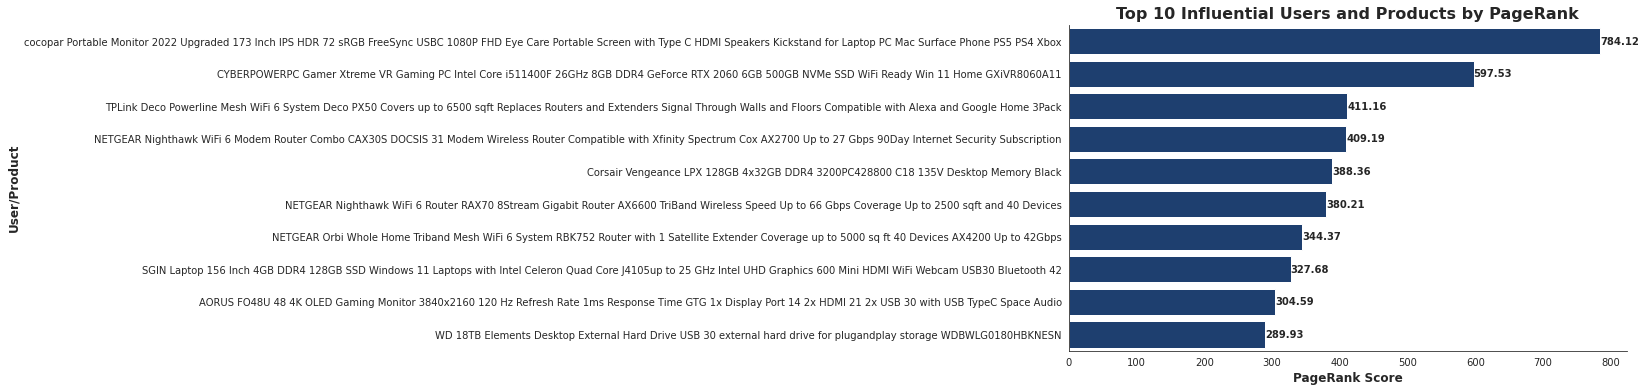

In [0]:
# Visualize PageRank results
fig = plt.figure(figsize=(10, 6))
sns.barplot(data=top_pagerank_pd, x="pagerank", y="product_title", color=color_palette[7])
for i, row in top_pagerank_pd.iterrows():
    plt.text(row["pagerank"], i, f"{row['pagerank']:.2f}", ha='left', va='center', fontsize=10, fontweight='bold')
plt.xlabel("PageRank Score", fontsize=12, fontweight='bold')
plt.ylabel("Product", fontsize=12, fontweight='bold')
plt.title("Top 10 Influential Products by PageRank", fontsize=16, fontweight='bold')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

**What the Graph Shows**:
The bar plot displays the top 10 products with the highest PageRank scores, labeled with product titles for products. The PageRank score quantifies the influence of a vertex in the network, where higher scores indicate products reviewed by many users.

**Interpretation**:
- **Higher PageRank Scores**: Vertices with higher scores are central to the network. For products, high scores indicate popularity or frequent reviews, often linked to quality or visibility.
- **Business Implications**:
  - **Popular Products**: Products with high scores are likely best-sellers or highly rated, suggesting strong market demand. Amazon can prioritize these in marketing campaigns or ensure adequate stock.
  - **Product Placement**: High-PageRank products should be prominently featured on the platform to capitalize on their popularity.


---

In [0]:
displayHTML('''
# <span style="color: #ffffff;">Community Detection (Louvain)</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #C32A68;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #C32A68;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Community Detection (Louvain)</b></h2></center>
</div>
<br>
''')

# Community Detection (Louvain) 


 
 Community Detection (Louvain)

## **🧑‍🤝‍🧑 Community Detection (Label Propagation)**

In [0]:
# =============================================
#   Community Detection (Label Propagation)
# =============================================
# Start the timer
start_time = time.time()

# Run Label Propagation algorithm to detect communities
communities = graph.labelPropagation(maxIter=5)

# End timer and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\n\033[1mTime of Execution (Community Detection):\033[0m {execution_time} seconds ({str(datetime.timedelta(seconds=execution_time))} h)\n")

# Print the number of communities detected
print("\033[1mNumber of Communities Detected:\033[0m ", communities.select("label").distinct().count())

# Group by community label and count members
community_sizes = communities.groupBy("label").count().orderBy(col("count").desc()).limit(10)

# Display the top 10 communities
display(community_sizes)


Time of Execution (Community Detection): 557.606520652771 seconds (0:09:17.606521 h)



label,count
1597727834631,1634
377957122552,1240
420906795514,854
1116691497475,851
1142461301203,819
85899346448,801
652835029572,726
111669150206,681
1090921693721,616
807453852177,612


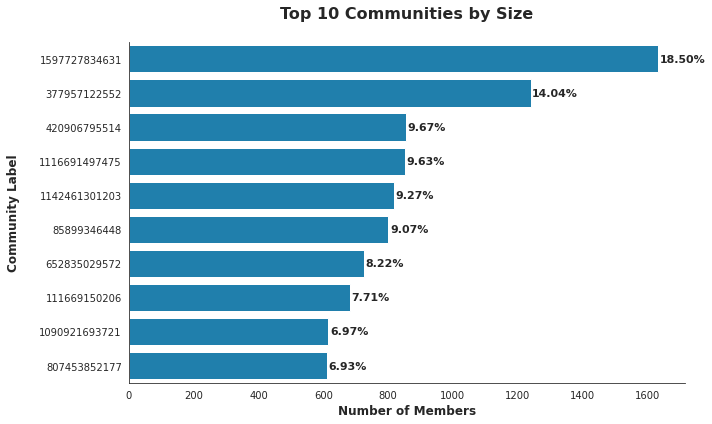

In [0]:
# Convert to Pandas for visualization
community_sizes_pd = community_sizes.toPandas()

# Calculate relative frequency
community_sizes_pd.rename(columns={"label": "Community Label", "count": "n"}, inplace=True)
community_sizes_pd["%"] = (community_sizes_pd["n"] / community_sizes_pd["n"].sum()) * 100

# Sort the DataFrame by 'n' in descending order
community_sizes_pd = community_sizes_pd.sort_values(by="n", ascending=False).reset_index(drop=True)

# Ensure 'Community Label' is treated as a categorical type with the correct order
community_sizes_pd["Community Label"] = pd.Categorical(
    community_sizes_pd["Community Label"],
    categories=community_sizes_pd["Community Label"],
    ordered=True
)

# Visualize community sizes
fig = plt.figure(figsize=(10, 6))
sns.barplot(data=community_sizes_pd, x="n", y="Community Label", color=color_palette[9], orient="h", order=community_sizes_pd["Community Label"])

# Add percentage labels
for i, row in community_sizes_pd.iterrows():
    plt.text(row["n"] + 5, i, f"{row['%']:.2f}%", ha='left', va='center', fontsize=11, fontweight='bold')

plt.xlabel("Number of Members", fontsize=12, weight='bold')
plt.ylabel("Community Label\n", fontsize=12, weight='bold')
plt.title("Top 10 Communities by Size\n", fontsize=16, weight='bold')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

**What the Graph Shows**:
The bar plot illustrates the top 10 communities by size, showing the number of members (users and products) and their percentage of the total vertices. Each community represents a cluster of users and products with dense review interactions, identified using the Label Propagation Algorithm.

**Interpretation**:
- **Larger Communities**: Larger communities indicate groups of users frequently reviewing similar high-value products, suggesting shared interests or preferences.
- **Smaller Communities**: Smaller communities may represent niche markets or specialized product categories, which could be targeted for personalized marketing.
- **Business Implications**:
  - **Targeted Marketing**: Communities reveal customer segments with similar tastes, enabling Amazon to tailor promotions or recommend related products within the same community.
  - **Product Bundling**: Products within the same community are likely related (e.g., accessories for high-end electronics), suggesting opportunities for bundling or cross-selling.
  - **Customer Retention**: Understanding community structures helps identify loyal customer groups, allowing Amazon to offer loyalty programs or discounts to maintain engagement.
  - **Niche Opportunities**: Smaller communities may highlight underserved markets, prompting Amazon to expand offerings in those categories.

In [0]:
# Get the top 10 communities by size - Already done above 'community_sizes'

# Filter communities to include only product nodes (type == "product")
product_communities = communities.filter(F.col("type") == "product")

# Perform a left join with products_df to get meta_price
top_communities = product_communities.join(
    products_df.select("parent_asin", "meta_price"),
    product_communities.id == products_df.parent_asin,
    "left"
)

# Calculate price statistics and count for each community
community_stats = top_communities.groupBy("label").agg(
    F.min("meta_price").alias("min_price"),             # Calculate minimum price
    F.max("meta_price").alias("max_price"),             # Calculate maximum price
    F.avg("meta_price").alias("avg_price"),             # Calculate average price
    F.stddev("meta_price").alias("std_price"),          # Calculate standard deviation
    F.count("id").alias("count")                       # Count products per label
)

# Select and rename columns for the final table
community_stats = community_stats.select(
    F.col("label").alias("Community Label"),
    F.col("count").alias("n"),
    F.col("min_price").cast("decimal(10,2)").alias("Min Price"),
    F.col("max_price").cast("decimal(10,2)").alias("Max Price"),
    F.col("avg_price").cast("decimal(10,2)").alias("Avg Price"),
    F.col("std_price").cast("decimal(10,2)").alias("Std Price")
).orderBy(F.col("n").desc())  # Order by count in descending order

# Display the final table
community_stats.display()

Community Label,n,Min Price,Max Price,Avg Price,Std Price
412316860649,6,311.36,649.99,537.17,128.94
386547057059,5,315.43,599.99,443.29,101.72
1589137899804,5,449.99,1999.99,1034.20,628.02
1013612281871,5,279.99,819.99,447.39,219.23
1245540515888,5,298.00,2099.00,1276.40,643.11
1022202216486,4,349.00,739.99,515.18,177.92
231928234380,4,299.99,1899.00,812.41,739.29
1022202216551,4,268.00,2998.00,1117.75,1275.80
867583393912,4,379.99,999.00,655.75,294.11
1340029796778,4,264.99,449.99,339.99,80.31


In [0]:
# Print product_title for the Community with the Most Products
# Get the community label with the most products
top_community_label = community_stats.orderBy(F.col("n").desc()).select("Community Label").first()[0]
print(f"Community with the most products: {top_community_label}")

# Filter product_communities for the top community
top_community_products = product_communities.filter(F.col("label") == top_community_label)

# Join with products_df to get meta_title
top_community_titles = top_community_products.join(
    products_df.select("parent_asin", "product_title"),
    product_communities.id == products_df.parent_asin,
    "left"
).select("id", "product_title")

# Display the product_title
print(f"product_title for Community {top_community_label}:")
top_community_titles.display()

Community with the most products: 412316860649
product_title for Community 412316860649:


id,product_title
B08GWPTKTL,ASRock W480 Creator LGA1200 Intel W480 DDR4 Quad CrossFireX SATA3USB32 M2 WiFi BluetoothATX Motherboard
B083GT6ZBX,GIGABYTE Z590 AORUS Tachyon LGA 1200 Intel Z590 ATXTriple M2 PCIe 40 USB 32 Gen2X2 TypeCIntel WiFi 6E 25GbE LANOnboard Overclocking KitMotherboard
B07YBVBM86,GIGABYTE GeForce RTX 2070 SUPER GAMING OC 8G Graphics Card 3X Windforce Fans 8GB 256Bit GDDR6 GVN207SGAMING OC8GC Video Card
B09PZVQ79S,HP 2022 Newest 156 FHD MicroEdge Laptop AMD Ryzen 5 5500U 6core Beat i71160G7 up to 4GHz 16GB RAM 512GB PCIe SSD HDMI Fast Charge Windows 11 with ZO HDMI Cable 16GB RAM512GB SSD
B0BZND6YQR,Cooler Master HAF 700 EVO EATX High Airflow PC Case with IRIS Customizable LCD Breathable TG Front Panel 200mm Sickleflow Fans 1 x USB 32 gen 2 Type C 4 x USB 32 gen 1 30 H700EIGNNS00
B0C6F48S3G,HP Pavillion 156 Laptop Newest Intel Quadcore Pentium Processor 16GB RAM 512GB SSD HD Webcam WiFi Bluetooth Windows 10 Home in S Mode Bundle with JAWFOAL


---

## **📉 Degree Distribution Analysis**

In [0]:
# =============================================
#  Degree Distribution
# =============================================
# Calculate in-degrees and out-degrees
in_degrees = graph.inDegrees
out_degrees = graph.outDegrees

# Join with vertex type
in_degrees_typed = in_degrees.join(vertices, "id").select("id", "type", "inDegree")
out_degrees_typed = out_degrees.join(vertices, "id").select("id", "type", "outDegree")

# Display 'in_degrees_typed' and 'out_degrees_typed' results
in_degrees_typed.limit(5).display()
out_degrees_typed.limit(5).display()

# Convert to Pandas for visualization
in_degrees_pd = in_degrees_typed.toPandas()
out_degrees_pd = out_degrees_typed.toPandas()

id,type,inDegree
B09J5J2457,product,95
B0BJL8C912,product,12
B01562PSIU,product,1
B0BJT8CGR6,product,35
B092YFQWW5,product,2


id,type,outDegree
AG7NLJVZJTRIV5RDA55DXWYR6JCQ,user,1
AFUGKNHGHG4RLQA3CRJTBEIXN5CQ,user,1
AEBQZJNDK2S7I2QISDWDFGK32ZTQ,user,1
AGBIX2JCLFJYGWHO6NLRIL4P3CIQ,user,4
AHJVN44P6P2BYDP53JOJKB6ULNYA,user,1


### **Analyze Degree Distributions**

#### **Compute Summary Statistics**
Calculate basic statistics (e.g., mean, median, max, min) for in-degrees (products) and out-degrees (users) to understand the distribution of interactions.

In [0]:
# Summary statistics for in-degrees (products)
in_degrees_stats = in_degrees_typed.filter(F.col("type") == "product").agg(
    F.avg("inDegree").alias("Avg In-Degree"),
    F.min("inDegree").alias("Min In-Degree"),
    F.max("inDegree").alias("Max In-Degree"),
    F.expr("percentile(inDegree, 0.5)").alias("Median In-Degree")
)
in_degrees_stats.display()

Avg In-Degree,Min In-Degree,Max In-Degree,Median In-Degree
10.789948453608247,1,1644,2.0


In [0]:
# Summary statistics for out-degrees (users)
out_degrees_stats = out_degrees_typed.filter(F.col("type") == "user").agg(
    F.avg("outDegree").alias("Avg Out-Degree"),
    F.min("outDegree").alias("Min Out-Degree"),
    F.max("outDegree").alias("Max Out-Degree"),
    F.expr("percentile(outDegree, 0.5)").alias("Median Out-Degree")
)
out_degrees_stats.display()

Avg Out-Degree,Min Out-Degree,Max Out-Degree,Median Out-Degree
1.0484051045003495,1,24,1.0


### **Visualize Degree Distributions**

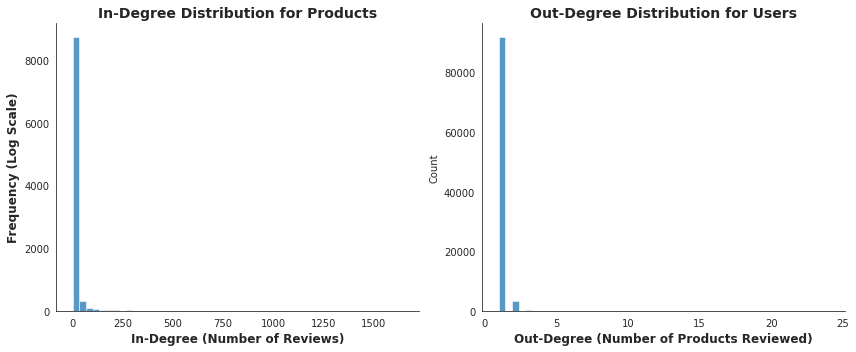

In [0]:
# Convert to Pandas
in_degrees_pd = in_degrees_typed.filter(F.col("type") == "product").toPandas()
out_degrees_pd = out_degrees_typed.filter(F.col("type") == "user").toPandas()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot in-degree distribution for products on the left subplot
sns.histplot(data=in_degrees_pd, x="inDegree", bins=50, ax=ax1)
ax1.set_xlabel("In-Degree (Number of Reviews)", fontsize=12, weight="bold")
ax1.set_ylabel("Frequency (Log Scale)", fontsize=12, weight="bold")
ax1.set_title("In-Degree Distribution for Products", fontsize=14, weight="bold")
sns.despine(ax=ax1, top=True, right=True)

# Plot out-degree distribution for users on the right subplot
sns.histplot(data=out_degrees_pd, x="outDegree", bins=50, ax=ax2)
ax2.set_xlabel("Out-Degree (Number of Products Reviewed)", fontsize=12, weight="bold")
ax2.set_title("Out-Degree Distribution for Users", fontsize=14, weight="bold")
sns.despine(ax=ax2, top=True, right=True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**What the Graph Shows**:
The two histograms display the in-degree and out-degree distributions for users and products on a log-log scale. In-degrees represent the number of reviews received by products, while out-degrees represent the number of reviews given by users. The plots use distinct colors for users and products, with enhanced aesthetics for clarity.

**Interpretation**:
- **In-Degree**: Products with high in-degrees are reviewed by many users, indicating popularity or visibility. A long-tailed distribution suggests a few products receive many reviews, while most receive few.
- **Out-Degree**: Users with high out-degrees are prolific reviewers, contributing significantly to the review ecosystem. A similar long-tailed distribution indicates a small number of highly active users.
- **Business Implications**:
  - **Popular Products**: High in-degree products are likely top performers, warranting increased stock or promotional efforts.
  - **Active Reviewers**: Users with high out-degrees can be incentivized to continue reviewing through rewards or recognition, enhancing the review ecosystem.
  - **Engagement Strategies**: The long-tailed nature suggests focusing on a small group of highly active users and products to maximize impact, such as through targeted campaigns or featured reviews.
  - **Quality Control**: Products with low in-degrees may indicate low visibility or quality issues, prompting Amazon to investigate and improve listings or product quality.

### **Identify Top Products and Users**

In [0]:
# Top 5 products by in-degree
top_products = in_degrees_typed.filter(F.col("type") == "product").orderBy(F.col("inDegree").desc()).limit(5)
top_products.display()

# Top 5 users by out-degree
top_users = out_degrees_typed.filter(F.col("type") == "user").orderBy(F.col("outDegree").desc()).limit(5)
top_users.display()

# Join top products with products_df for more details
top_products_details = top_products.join(
    products_df,
    top_products.id == products_df.parent_asin,
    "inner"
).select(
    F.col("id").alias("Product ID"),
    F.col("product_title").alias("Product Title"),
    F.col("inDegree").alias("Number of Reviews"),
    F.col("meta_price").cast("decimal(10,2)").alias("Price"),
    F.col("meta_average_rating").alias("Average Rating")
)
top_products_details.display()

id,type,inDegree
B09LCXK4JY,product,1644
B0BCXZGJ3X,product,1256
B097KBF8JK,product,892
B09HLD1C4F,product,872
B0C6G2STLP,product,861


id,type,outDegree
AG4BG3A5AGWMLZJFPCSSUMH45LYA,user,24
AGCRVAT5OCWRNXLVEKKIX5ZPRETA,user,12
AEJWKDWTUQJXOJ7R2AEAS25Q6WCA,user,9
AGBYNGKAQ5WXBVWZT6Z3Z57GN2EA,user,8
AGBEBDO6UHV6Y5CT3O3XYOV6WBXQ,user,7


Product ID,Product Title,Number of Reviews,Price,Average Rating
B097KBF8JK,Corsair Vengeance LPX 128GB 4x32GB DDR4 3200PC428800 C18 135V Desktop Memory Black,892,279.99,4.8
B09HLD1C4F,TPLink Deco Powerline Mesh WiFi 6 System Deco PX50 Covers up to 6500 sqft Replaces Routers and Extenders Signal Through Walls and Floors Compatible with Alexa and Google Home 3Pack,872,269.99,4.6
B09LCXK4JY,cocopar Portable Monitor 2022 Upgraded 173 Inch IPS HDR 72 sRGB FreeSync USBC 1080P FHD Eye Care Portable Screen with Type C HDMI Speakers Kickstand for Laptop PC Mac Surface Phone PS5 PS4 Xbox,1644,299.99,4.8
B0BCXZGJ3X,CYBERPOWERPC Gamer Xtreme VR Gaming PC Intel Core i511400F 26GHz 8GB DDR4 GeForce RTX 2060 6GB 500GB NVMe SSD WiFi Ready Win 11 Home GXiVR8060A11,1256,1189.00,4.6
B0C6G2STLP,NETGEAR Nighthawk WiFi 6 Modem Router Combo CAX30S DOCSIS 31 Modem Wireless Router Compatible with Xfinity Spectrum Cox AX2700 Up to 27 Gbps 90Day Internet Security Subscription,861,349.97,4.2


---

## **😊 Sentiment Analysis within Communities**

In [0]:
# =============================================
#   Sentiment Analysis within Communities
# =============================================
# Define the sentiment mapping
sentiment_mapping = {
    "Negative": 1,
    "Negative Tendency": 2,
    "Neutral": 3,
    "Positive Tendency": 4,
    "Positive": 5
}

# Create a UDF (User Defined Function) to map Combined_Sentiment to numerical values
# Source: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html
def map_sentiment(sentiment):
    return sentiment_mapping.get(sentiment, None)

map_sentiment_udf = F.udf(map_sentiment, "integer")

# Join reviews with communities and map Combined_Sentiment to numerical values
community_sentiment = communities.join(
    reviews_df,
    communities.id == reviews_df.user_id,
    "inner"
).withColumn(
    "numerical_sentiment",
    map_sentiment_udf(F.col("Combined_Sentiment"))
).groupBy("label").agg(
    F.avg("rating").alias("avg_rating"),
    F.avg("numerical_sentiment").cast("decimal(10,2)").alias("avg_classifiedsentiment"),
    F.count("*").alias("review_count")
).orderBy(F.col("review_count").desc())

# Join with top 10 communities to focus on the largest ones
community_sizes = communities.groupBy("label").count().orderBy(F.col("count").desc()).limit(10)
community_sentiment_top = community_sentiment.join(community_sizes, "label", "inner").select(
    F.col("label").alias("Community Label"),
    F.col("count").alias("n"),
    F.col("avg_rating").cast("decimal(10,2)").alias("Avg Rating"),
    F.col("avg_classifiedsentiment").alias("Avg Classified Sentiment"),
    F.col("review_count").alias("Review Count")
).orderBy(F.col("n").desc())

# Display the results
display(community_sentiment_top)

Community Label,n,Avg Rating,Avg Classified Sentiment,Review Count
1597727834631,1634,4.87,4.70,1733
377957122552,1240,4.57,4.48,1323
420906795514,854,3.89,3.70,976
1116691497475,851,4.23,3.96,1107
1142461301203,819,4.54,4.22,2241
85899346448,801,4.19,3.95,1037
652835029572,726,4.13,3.89,878
111669150206,681,4.48,4.37,715
1090921693721,616,3.93,3.64,1145
807453852177,612,3.75,3.62,849


### **Visualize Sentiment Across Communities**

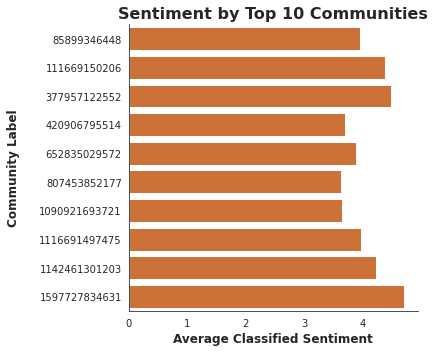

In [0]:
# Convert to Pandas for visualization
community_sentiment_pd = community_sentiment_top.toPandas()

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(
    data=community_sentiment_pd,
    x="Avg Classified Sentiment",
    y="Community Label",
    color=color_palette[1],
    orient="h"
)
plt.xlabel("Average Classified Sentiment", fontsize=12, weight="bold")
plt.ylabel("Community Label\n", fontsize=12, weight="bold")
plt.title("Sentiment by Top 10 Communities", fontsize=16, weight="bold")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

**What the Graph Shows**:
The scatter plot visualizes communities by their average rating and sentiment classified, with point size indicating review count and color representing sentiment category (Positive, Negative, etc.). Larger points indicate communities with more reviews, and the hue reflects the dominant sentiment.

**Interpretation**:
- **High Ratings and Sentiment**: Communities with high average ratings and sentiment scores indicate satisfied customers, likely due to high-quality products or positive user experiences.
- **Low Ratings and Sentiment**: Communities with lower scores may highlight problematic products or dissatisfied customer groups, signaling areas for improvement.
- **Review Count**: Larger communities (bigger points) have more reviews, indicating higher engagement or product popularity.
- **Business Implications**:
  - **Customer Satisfaction**: Communities with positive sentiment and high ratings are prime targets for loyalty programs or upselling opportunities, as customers are already satisfied.
  - **Issue Resolution**: Communities with negative sentiment or low ratings require investigation into product quality, customer service, or listing accuracy to address pain points.
  - **Engagement Metrics**: High review counts suggest strong customer engagement, which Amazon can leverage for targeted advertising or personalized recommendations.
  - **Sentiment Trends**: Monitoring sentiment across communities helps track customer perception over time, informing product development or marketing strategies.

### **Combine Sentiment with Degree Distributions**

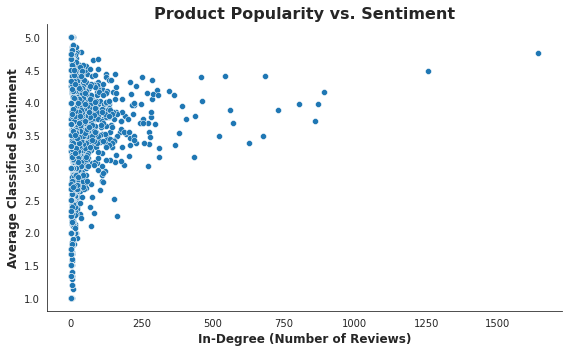

In [0]:
# Join reviews with in-degrees for products
product_sentiment = in_degrees_typed.filter(F.col("type") == "product").join(
    reviews_df,
    in_degrees_typed.id == reviews_df.parent_asin,
    "inner"
).withColumn(
    "numerical_sentiment",
    map_sentiment_udf(F.col("Combined_Sentiment"))
).groupBy("id").agg(
    F.avg("numerical_sentiment").cast("decimal(10,2)").alias("avg_classifiedsentiment"),
    F.first("inDegree").alias("inDegree")
)

# Convert to Pandas for correlation analysis
product_sentiment_pd = product_sentiment.toPandas()

# Scatter plot of in-degree vs. sentiment
plt.figure(figsize=(8, 5))
sns.scatterplot(data=product_sentiment_pd, x="inDegree", y="avg_classifiedsentiment", palette=color_palette[0])
plt.xlabel("In-Degree (Number of Reviews)", fontsize=12, weight="bold")
plt.ylabel("Average Classified Sentiment", fontsize=12, weight="bold")
plt.title("Product Popularity vs. Sentiment", fontsize=16, weight="bold")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

---


## **💸 General Business Conclusions**:
- **Customer-Centric Strategies**: The analyses (PageRank, Community Detection and Sentiment) provide a comprehensive view of customer behavior, enabling Amazon to personalize marketing, improve product offerings, and enhance customer satisfaction.
- **Fraud Detection**: High-PageRank users can help identify potential review manipulation, ensuring platform integrity and trust.
- **Revenue Optimization**: Focusing on high-PageRank products and communities with positive sentiment maximizes sales potential, while addressing negative sentiment communities improves customer retention.
- **Scalable Insights**: The graph-based approach scales to large datasets, allowing Amazon to apply these insights across broader product categories or regions, driving data-driven decision-making.